In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [ ]:
# Относительный путь к исходному файлу данных
relative_path = os.path.join("..", "data", "dataset_trajectories.csv")
data = pd.read_csv(relative_path, sep=';', encoding='utf-8')

In [ ]:
def count_outliers_by_planet(data, planet_column='target_body_name'):
    """
    Функция для подсчета выбросов в данных по каждой планете.

    Параметры:
    data (pd.DataFrame): Исходные данные.
    planet_column (str): Название столбца, содержащего названия планет.

    Возвращает:
    pd.DataFrame: Таблица с подсчетом выбросов по каждой планете и каждому числовому столбцу.
    """
    outliers_summary = pd.DataFrame()

    grouped_data = data.groupby(planet_column)
    for planet, group in grouped_data:
        for column in group.select_dtypes(include=['float64', 'int64']).columns:
            Q1 = group[column].quantile(0.25)
            Q3 = group[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            outliers_count = group[(group[column] < lower_bound) | (group[column] > upper_bound)].shape[0]

            outliers_summary = pd.concat([
                outliers_summary,
                pd.DataFrame({
                    'planet': [planet],
                    'column': [column],
                    'Q1': [Q1],
                    'Q3': [Q3],
                    'IQR': [IQR],
                    'lower_bound': [lower_bound],
                    'upper_bound': [upper_bound],
                    'outliers_count': [outliers_count]
                })
            ], ignore_index=True)

    return outliers_summary

# Копирование исходных данных для чистки
data_cleaned = data.copy()

# Уникальные планеты
planets = data['target_body_name'].unique()

# Чистка выбросов, заменяя их средними значениями
for planet in planets:
    data_planet = data_cleaned[data_cleaned['target_body_name'] == planet]
    
    for column in data_planet.columns:
        if pd.api.types.is_numeric_dtype(data_planet[column]):
            Q1 = data_planet[column].quantile(0.25)
            Q3 = data_planet[column].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            mean_value = data_planet[column].mean()
            
            # Заменяем выбросы на среднее значение
            data_cleaned.loc[
                (data_cleaned['target_body_name'] == planet) &
                ((data_cleaned[column] < lower_bound) | (data_cleaned[column] > upper_bound)),
                column
            ] = mean_value

# Подсчет выбросов после очистки
outliers_summary_all_columns2 = count_outliers_by_planet(data_cleaned)

# Путь для сохранения отчета по выбросам
relative_path1 = os.path.join("..", "data", "outlines_count_1.5IQR.csv")
outliers_summary_all_columns2.to_csv(relative_path1, index=False, sep=';', encoding='utf-8')

In [10]:
from scipy.stats.mstats import winsorize

In [ ]:
def winsorize_data_by_planet(data, planet_column='target_body_name', limits=(0.05, 0.05)):
    """
    Функция для винсоризации данных по каждой планете.

    Параметры:
    data (pd.DataFrame): Исходные данные.
    planet_column (str): Название столбца с планетами.
    limits (tuple): Границы винсоризации (например, (0.05, 0.05) для 5% отбрасывания на обоих концах).

    Возвращает:
    pd.DataFrame: Данные с примененной винсоризацией.
    """
    data_winsorized = data.copy()
    
    for planet in data[planet_column].unique():
        data_planet = data_winsorized[data_winsorized[planet_column] == planet]
        
        for column in data_planet.select_dtypes(include=['float64', 'int64']).columns:
            winsorized_values = winsorize(data_planet[column], limits=limits)
            data_winsorized.loc[data_winsorized[planet_column] == planet, column] = winsorized_values
    
    return data_winsorized

data_winsorized = winsorize_data_by_planet(data, limits=(0.05, 0.05))

outliers_summary_all_columns3 = count_outliers_by_planet(data_winsorized)
relative_path2 = os.path.join("..", "data", "outliers_count_winsorized.csv")
outliers_summary_all_columns3.to_csv(relative_path2, index=False, sep=';', encoding='utf-8')

In [12]:
from sklearn.ensemble import IsolationForest

In [ ]:
def isolation_forest_outliers(data, planet_column='target_body_name'):
    """
    Функция для использования алгоритма IsolationForest для выявления выбросов и их замены средними значениями.

    Параметры:
    data (pd.DataFrame): Исходные данные.
    planet_column (str): Название столбца с планетами.

    Возвращает:
    pd.DataFrame: Данные с замененными выбросами.
    """
    data_cleaned = data.copy()

    for planet in data[planet_column].unique():
        data_planet = data[data[planet_column] == planet]
        
        numeric_columns = data_planet.select_dtypes(include=['float64', 'int64']).columns
        clf = IsolationForest(contamination=0.05, random_state=0)
        
        data_planet['outlier'] = clf.fit_predict(data_planet[numeric_columns])
        
        for column in numeric_columns:
            mean_value = data_planet[column].mean()
            data_cleaned.loc[
                (data_cleaned[planet_column] == planet) & (data_planet['outlier'] == -1),
                column
            ] = mean_value

    return data_cleaned

data_isoforest_cleaned = isolation_forest_outliers(data)

outliers_summary_all_columns4 = count_outliers_by_planet(data_isoforest_cleaned)
relative_path3 = os.path.join("..", "data", "outliers_count_isoforest.csv")
outliers_summary_all_columns4.to_csv(relative_path3, index=False, sep=';', encoding='utf-8')

save_dir="..\\data"
file_path4 = os.path.join(save_dir, "outliers_count_isoforest.csv")
data = pd.read_csv(file_path4, sep=';', encoding='utf-8')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/tmp/ipykernel_2251/3662051414.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_planet['outlier'] = clf.fit_predict(data_planet[numeric_columns])
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/tmp/ipykernel_2251/3662051414.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [ ]:
# Подсчет выбросов с использованием нового коэффициента для IQR
def count_outliers_by_planet(data, planet_column='target_body_name'):
    """
    Подсчет выбросов с учетом нового коэффициента для IQR.

    Параметры:
    data (pd.DataFrame): Исходные данные.
    planet_column (str): Название столбца с планетами.

    Возвращает:
    pd.DataFrame: Итоговый отчет по выбросам для каждого столбца.
    """
    outliers_summary = pd.DataFrame()

    grouped_data = data.groupby(planet_column)
    for planet, group in grouped_data:
        for column in group.select_dtypes(include=['float64', 'int64']).columns:
            Q1 = group[column].quantile(0.25)
            Q3 = group[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 2.5 * IQR
            upper_bound = Q3 + 2.5 * IQR

            outliers_count = group[(group[column] < lower_bound) | (group[column] > upper_bound)].shape[0]

            outliers_summary = pd.concat([
                outliers_summary,
                pd.DataFrame({
                    'planet': [planet],
                    'column': [column],
                    'Q1': [Q1],
                    'Q3': [Q3],
                    'IQR': [IQR],
                    'lower_bound': [lower_bound],
                    'upper_bound': [upper_bound],
                    'outliers_count': [outliers_count]
                })
            ], ignore_index=True)

    return outliers_summary

# Финальная очистка данных и подсчет выбросов
data_cleaned = data.copy()

planets = data['target_body_name'].unique()

for planet in planets:
    data_planet = data_cleaned[data_cleaned['target_body_name'] == planet]
    
    for column in data_planet.columns:
        if pd.api.types.is_numeric_dtype(data_planet[column]):
            Q1 = data_planet[column].quantile(0.25)
            Q3 = data_planet[column].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - 2.5 * IQR
            upper_bound = Q3 + 2.5 * IQR
            
            mean_value = data_planet[column].mean()
            
            data_cleaned.loc[
                (data_cleaned['target_body_name'] == planet) &
                ((data_cleaned[column] < lower_bound) | (data_cleaned[column] > upper_bound)),
                column
            ] = mean_value

# Подсчет финальных выбросов
result_outliers_summary = count_outliers_by_planet(data_cleaned)

relative_path4 = os.path.join("..", "data", "final_outlines_count.csv")
result_outliers_summary.to_csv(relative_path4, index=False, sep=';', encoding='utf-8')
relative_path5 = os.path.join("..", "data", "cleaned_dataset_trajectories")
data_cleaned.to_csv(relative_path5, index=False, sep=';', encoding='utf-8')

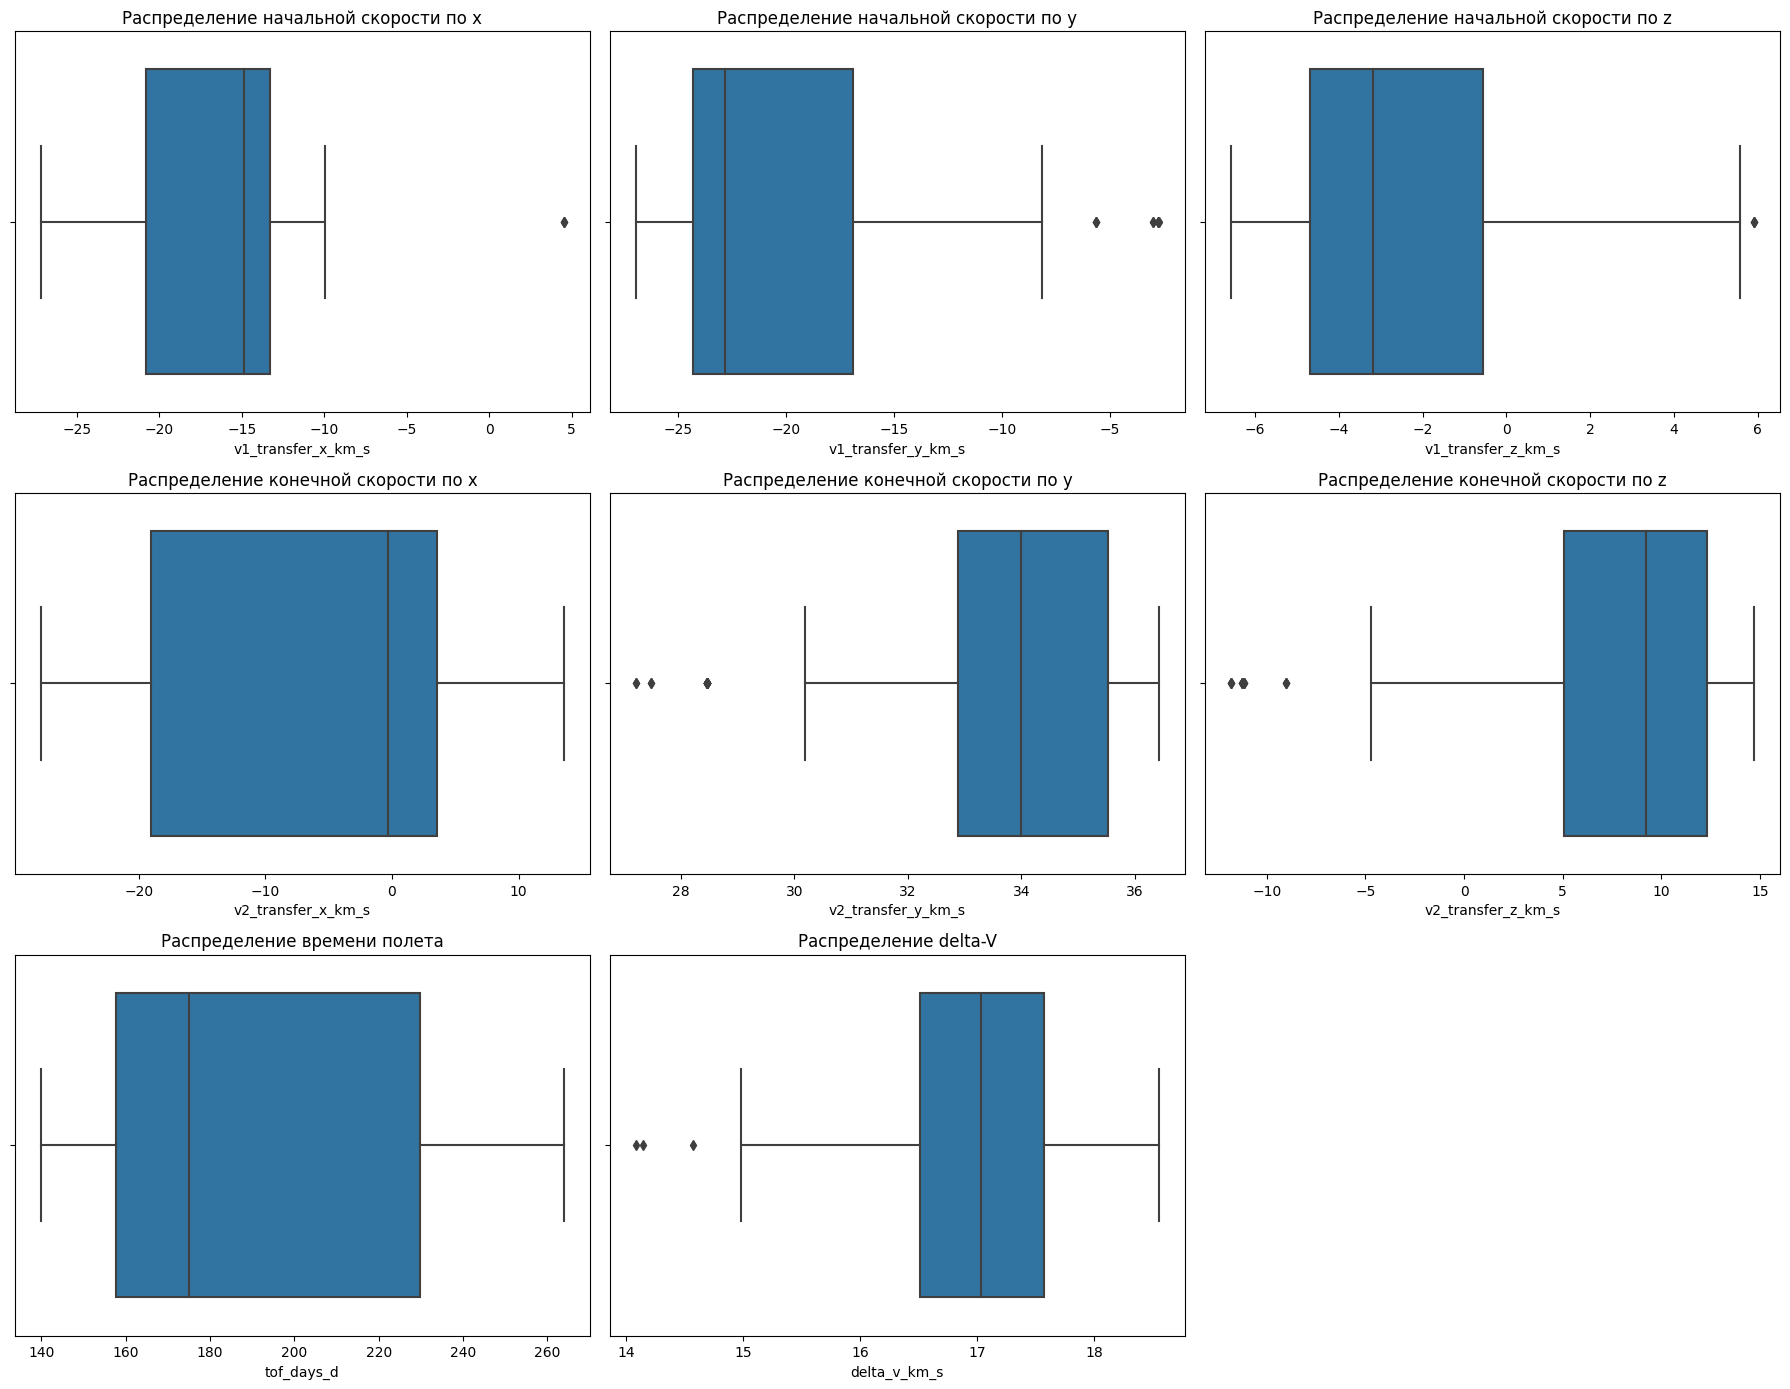

In [ ]:
# Визуализация распределения переменных по Венере
plt.figure(figsize=(18, 14))
data_venus = data_cleaned[data_cleaned['target_body_name'] == "Venus"]
# Начальная скорость по x
plt.subplot(3, 3, 1)
sns.boxplot(x=data_venus['v1_transfer_x_km_s'])
plt.title("Распределение начальной скорости по x")

# Начальная скорость по y
plt.subplot(3, 3, 2)
sns.boxplot(x=data_venus['v1_transfer_y_km_s'])
plt.title("Распределение начальной скорости по y")

# Начальная скорость по z
plt.subplot(3, 3, 3)
sns.boxplot(x=data_venus['v1_transfer_z_km_s'])
plt.title("Распределение начальной скорости по z")

# Конечная скорость по x
plt.subplot(3, 3, 4)
sns.boxplot(x=data_venus['v2_transfer_x_km_s'])
plt.title("Распределение конечной скорости по x")

# Конечная скорость по y
plt.subplot(3, 3, 5)
sns.boxplot(x=data_venus['v2_transfer_y_km_s'])
plt.title("Распределение конечной скорости по y")

# Конечная скорость по z
plt.subplot(3, 3, 6)
sns.boxplot(x=data_venus['v2_transfer_z_km_s'])
plt.title("Распределение конечной скорости по z")

# Время полета
plt.subplot(3, 3, 7)
sns.boxplot(x=data_venus['tof_days_d'])
plt.title("Распределение времени полета")

# Delta-V
plt.subplot(3, 3, 8)
sns.boxplot(x=data_venus['delta_v_km_s'])
plt.title("Распределение delta-V")

plt.tight_layout()
plt.show()